In [8]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:

# Loading the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Augmening Data
    transforms.RandomCrop(32, padding=4), # Augmenting Data
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [04:56<00:00, 574156.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class VGG8(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG8, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
# Setting up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG8().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 20
patience = 5
best_val_loss = 99999

In [6]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(valloader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break


Epoch 1/20, Training Loss: 2.2532, Training Accuracy: 0.1269, Validation Loss: 2.1405, Validation Accuracy: 0.1734
Epoch 2/20, Training Loss: 1.8370, Training Accuracy: 0.2847, Validation Loss: 1.6667, Validation Accuracy: 0.3641
Epoch 3/20, Training Loss: 1.5360, Training Accuracy: 0.4213, Validation Loss: 1.4785, Validation Accuracy: 0.4526
Epoch 4/20, Training Loss: 1.2833, Training Accuracy: 0.5331, Validation Loss: 1.1679, Validation Accuracy: 0.5835
Epoch 5/20, Training Loss: 1.0834, Training Accuracy: 0.6121, Validation Loss: 1.0518, Validation Accuracy: 0.6201
Epoch 6/20, Training Loss: 0.9512, Training Accuracy: 0.6637, Validation Loss: 0.8664, Validation Accuracy: 0.6917
Epoch 7/20, Training Loss: 0.8496, Training Accuracy: 0.7037, Validation Loss: 0.7820, Validation Accuracy: 0.7246
Epoch 8/20, Training Loss: 0.7725, Training Accuracy: 0.7297, Validation Loss: 0.7460, Validation Accuracy: 0.7445
Epoch 9/20, Training Loss: 0.6923, Training Accuracy: 0.7611, Validation Loss: 0

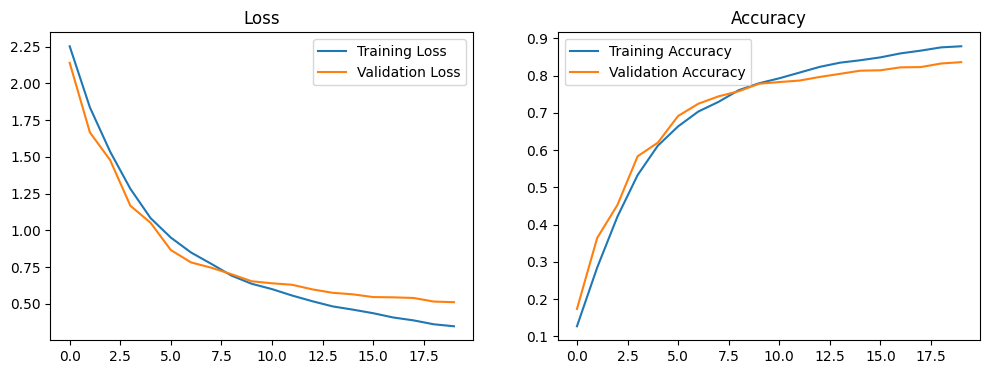

In [9]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()


In [10]:
# Evaluating the model on test data
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().detach().numpy())  # Move to CPU before converting to numpy
            ground_truth.extend(labels.cpu().detach().numpy())    # Move to CPU before converting to numpy
    accuracy = correct / total * 100

    conf_matrix = confusion_matrix(ground_truth, predictions)
    return accuracy, conf_matrix


accuracy, conf_matrix = test(model, testloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.32%


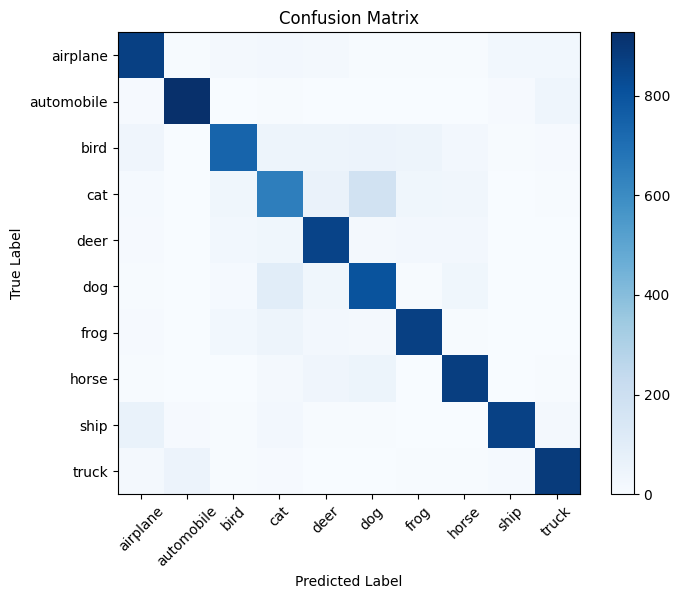

Confusion Matrix:
[[869   4  16  22  21   4   6   5  27  26]
 [  8 927   3   7   2   2   0   0   8  43]
 [ 39   1 739  44  46  51  45  22   5   8]
 [ 13   2  33 646  59 176  34  29   1   7]
 [ 10   2  28  33 856  21  23  23   3   1]
 [  6   3  13  99  33 802   7  33   1   3]
 [  9   2  28  44  23  19 869   4   1   1]
 [  7   0   3  20  39  50   1 874   0   6]
 [ 62   8   6  23   4   6   3   2 865  21]
 [ 19  52   6   8   2   2   7   5  14 885]]


In [11]:
# Display the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(10)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Confusion Matrix:")
print(conf_matrix)
